In [1]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os
import json

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


In [2]:
def get_A(p, params):
  OP = params['op']

  rC = p[0]

  A11 = - (params['rL'] / params['L'])
  A12 = - (1. / params['L'])
  A21 = 1. / params['C']
  A22 = (1. / params['C']) * (OP['Pcpl'] /
                              (OP['vC'] ** 2) - 1. / rC)

  return np.array([[A11, A12],
                   [A21, A22]])


def get_B(p, params):
  vIn = p[1]
  B11 = vIn / params['L']
  B21 = 0.
  return np.array([[B11],
                   [B21]])


def get_E(p, params):
  OP = params['op']
  E11 = 0.
  E21 = - (1. / (params['C'] * OP['vC']))
  return np.array([[E11],
                   [E21]])


def get_C(p):
  return np.array([[0., 1.]])

In [3]:
def sign(n):
  if n > 0.:
    return 1.
  elif n < 0.:
    return -1.
  return 0.


def sat(u, u_bar):
  return sign(u) * min(u_bar, abs(u))


def plant_update(time, states, inputs, params):

  n_u = params['amounts']['u']
  n_p = params['amounts']['p']
  n_w = params['amounts']['w']

  u = inputs[0:n_u].reshape(-1, 1)
  p = inputs[n_u:n_u + n_p]
  w = inputs[n_u + n_p:n_u + n_p + n_w].reshape(-1, 1)

  x = states.reshape(-1, 1)

  A = get_A(p, params)
  B = get_B(p, params)
  E = get_E(p, params)

  x_dot = A @ x + B @ u + E @ w

  return x_dot


amounts = {
    "amounts": {'x': 2, 'p': 2, 'u': 1, 'w': 1}
}

states = [f'x{i+1}' for i in range(amounts["amounts"]['x'])]
inputs = ([f'u{i+1}' for i in range(amounts["amounts"]['u'])] +
          [f'p{i+1}' for i in range(amounts["amounts"]['p'])] +
          [f'w{i+1}' for i in range(amounts["amounts"]['w'])])
outputs = states

plant = ct.nlsys(plant_update, None, name="plant",
                 inputs=inputs, outputs=outputs, states=states)

print(plant)

<NonlinearIOSystem>: plant
Inputs (4): ['u1', 'p1', 'p2', 'w1']
Outputs (2): ['x1', 'x2']
States (2): ['x1', 'x2']

Update: <function plant_update at 0x7e4760e57ce0>
Output: None


In [4]:
def create_params(V_IN, RL, RC, L, C, PCPL_OP, VC_OP):
  """
  Create a dictionary of parameters for the system model.

  Parameters:
                  V_IN (float): Input voltage.
                  RL (float): Resistance of the inductor.
                  RC (float): Resistance of the capacitor.
                  L (float): Inductance.
                  C (float): Capacitance.
                  PCPL_OP (float): Operating power of the CPL.
                  VC_OP (float): Operating voltage of the capacitor.

  Returns:
                  dict: Dictionary of system parameters.

  """
  # Calculate the operating point (OP) values for inductor current and duty cycle
  IL_OP = (VC_OP / RC) + PCPL_OP / VC_OP
  D_OP = (RL * IL_OP) / V_IN + VC_OP / V_IN

  # Create the dictionary of parameters
  params = {
      "Vin": V_IN,
      "rL": RL,
      "rC": RC,
      "L": L,
      "C": C,
      "op": {"Pcpl": PCPL_OP, "vC": VC_OP, "iL": IL_OP, "d": D_OP},
  }

  return params

∫|w(t)|dt =  0.0
{'Vin': 15, 'rL': 0.2, 'rC': 6, 'L': 0.001, 'C': 0.0022, 'op': {'Pcpl': 15, 'vC': 5, 'iL': 3.8333333333333335, 'd': 0.3844444444444444}, 'amounts': {'x': 2, 'p': 2, 'u': 1, 'w': 1}}
ubar: [0.3844444444444444]


/tmp/ipykernel_25989/3530609045.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


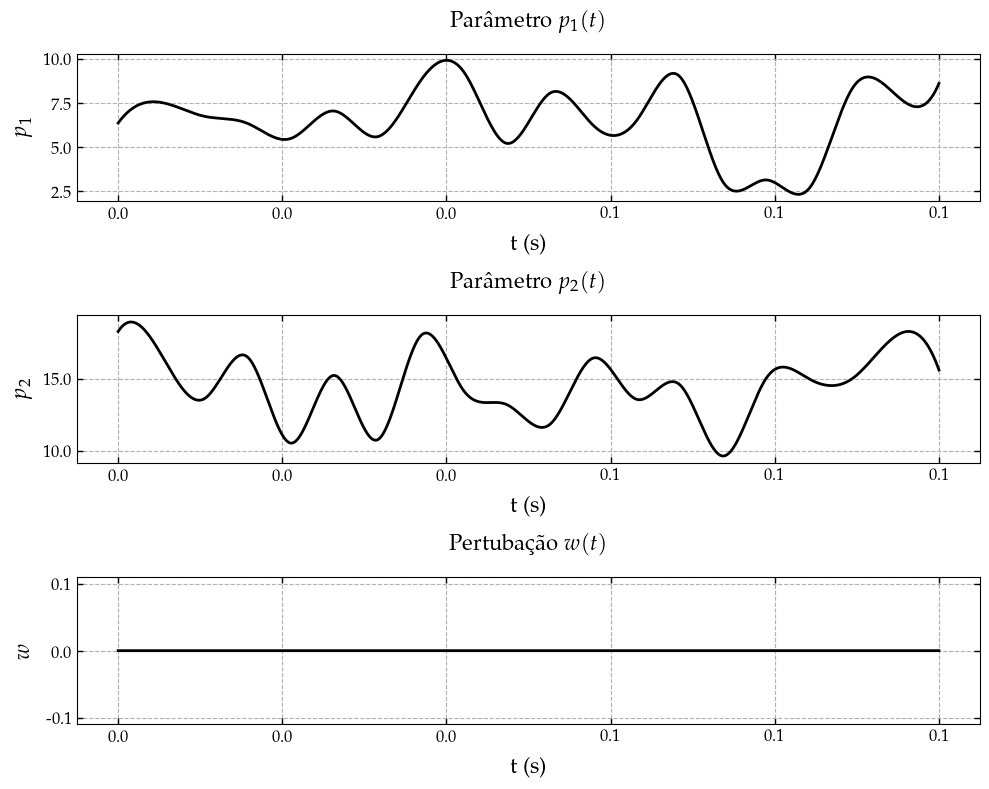

In [ ]:
%matplotlib inline

from scipy.interpolate import interp1d

simulation_step = 1e-6
simulation_time = 0.1
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# Entrada para simulação em malha aberta
δd = np.zeros((1, len(timepts)))
δPcpl = np.zeros((1, len(timepts)))
# δPcpl = 35 * np.exp(-75 * timepts) * np.sin(100 * np.pi * timepts)

integral_w_norm = np.sum(δPcpl**2) * (timepts[1] - timepts[0])
print('∫|w(t)|dt = ', integral_w_norm)

p_bounds = np.array([[2.0, 10.0],
                     [9.0, 19.0]])

np.random.seed(0)

# Pontos de controle esparsos
segment_count = 20
ctrl_times = np.linspace(timepts[0], timepts[-1], segment_count)

# Geração dos valores base com limites definidos
rc_ctrl_values = np.random.uniform(2.5, 9.5, size=segment_count)
vin_ctrl_values = np.random.uniform(9.5, 18.5, size=segment_count)

# Interpolação suave (cúbica) entre os valores
rc_interp = interp1d(ctrl_times, rc_ctrl_values, kind='cubic')
vin_interp = interp1d(ctrl_times, vin_ctrl_values, kind='cubic')

# Geração dos sinais finais
Rc = rc_interp(timepts)
vIn = vin_interp(timepts)

params = create_params(
    V_IN=15, RL=.2, RC=6, L=1e-3,
    C=2.2e-3, PCPL_OP=15, VC_OP=5
)
params.update(amounts)
print(params)

u_bar = [min(1 - params['op']['d'], params['op']['d'])]
print('ubar:', u_bar)

x_bounds = [(-1., 1.), 
            (-1., 1.)]

fig = plt.figure(figsize=(10, 8), layout='constrained')
axs = fig.subplot_mosaic([["Rc"], ["vIn"], ['Pcpl']])

gph.plot(
    axs['Rc'],
    timepts, Rc,
    't (s)',
    '$p_1$',
    'Parâmetro $p_1(t)$',
)

gph.plot(
    axs['vIn'],
    timepts, vIn,
    't (s)',
    '$p_2$',
    'Parâmetro $p_2(t)$',
)

gph.plot(
    axs['Pcpl'],
    timepts, δPcpl.reshape(-1, 1),
    't (s)',
    '$w$',
    'Pertubação $w(t)$',
)

plt.tight_layout()

In [6]:
t, y = ct.input_output_response(
    sys=plant, T=timepts,
    U=[δd, Rc, vIn, δPcpl,],
    X0=[2.5, 2.5],
    params=params
)

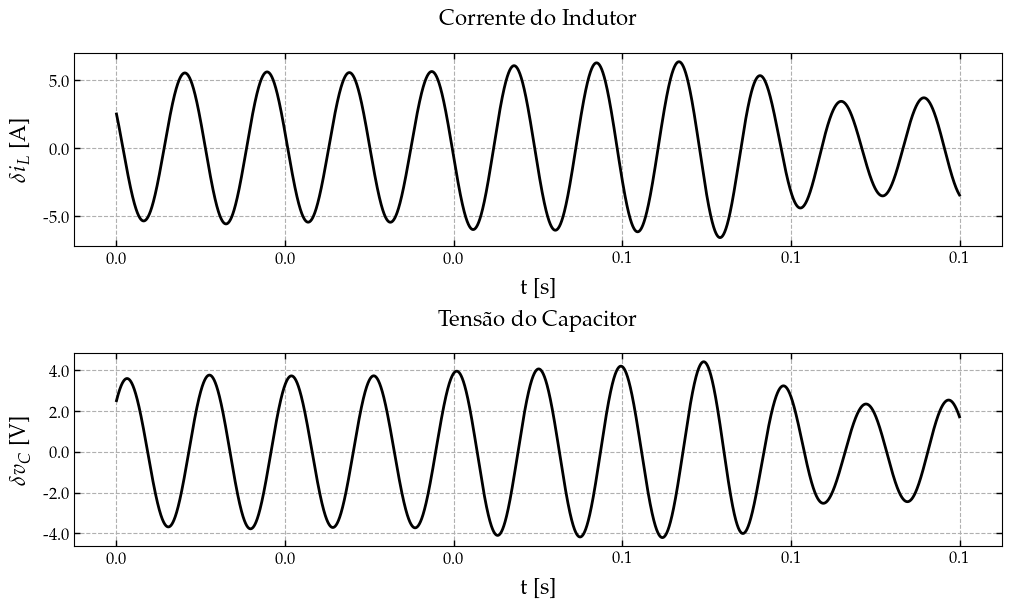

In [7]:
fig = plt.figure(figsize=(10, 6), layout='constrained')
axs = fig.subplot_mosaic([["iL"], ["vC"]])

gph.plot(
    axs['iL'], timepts, y[0],
    't [s]', '$\\delta i_L$ [A]',
    'Corrente do Indutor',
)

gph.plot(
    axs['vC'], timepts, y[1],
    't [s]', '$\\delta v_C$ [V]',
    'Tensão do Capacitor',
)

In [18]:
def He(M): return M + M.T


def get_parameter(h, υ, eps=1e-6):

  n_u = params['amounts']['u']
  n_p = params['amounts']['p']
  n_x = params['amounts']['x']
  n_w = params['amounts']['w']
  n_z = 1

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))
  O2nx = np.zeros((2 * n_x, 2 * n_x))

  A = {}
  B = {}
  C = {}
  E = {}

  for i in Bnp:
    pi = [p_bounds[idx][i[idx]] for idx in range(n_p)]
    A[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]', value=get_A(pi, params))
    B[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]', value=get_B(pi, params))
    C[i] = cp.Parameter((n_z, n_x), name=f'C[{i}]', value=get_C(pi))
    E[i] = cp.Parameter((n_x, n_w), name=f'E[{i}]', value=get_E(pi, params))

  e = {}
  _es = np.eye(n_x)
  _ef = np.zeros((n_x, 4 * n_x))
  e[1] = np.block([[_es, _ef, np.zeros((n_x, 1 + n_u))]])
  e[5] = np.block([[_ef, _es, np.zeros((n_x, 1 + n_u))]])

  for i in range(2, 5):
    e[i] = np.block([[np.zeros((n_x, n_x * (i - 1))),
                      np.eye(n_x),
                      np.zeros((n_x, n_x * (5 - i))),
                      np.zeros((n_x, 1 + n_u))]])

  e[6] = np.block(
      [[np.zeros((1,  5 * n_x)), np.eye(1), np.zeros((1, n_u))]])

  e[7] = np.block(
      [[np.zeros((n_u,  5 * n_x + 1)), np.eye(n_u)]])

  for i in range(1, 8):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  constraints = []

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((2 * n_x + n_u, 2 * n_x + n_u), PSD=True)
  Q1til = cp.Variable((n_x, n_x), symmetric=True)
  Q2til = cp.Variable((n_x, n_x))
  Q3til = cp.Variable((n_x, n_u))
  Q4til = cp.Variable((n_x, n_x))
  S1til = cp.Variable((n_x, n_x), symmetric=True)
  S2til = cp.Variable((n_x, n_x))
  S3til = cp.Variable((n_x, n_u))
  S4til = cp.Variable((n_x, n_x))

  Ktil = {}
  L1til = {}
  L2til = {}
  ℵ = {}

  for i in Bnp:
    Ktil[i] = cp.Variable((n_u, n_x), name=f'K[{i}]')
    L1til[i] = cp.Variable((n_u, n_x), name=f'L1[{i}]')
    L2til[i] = cp.Variable((n_u, n_x), name=f'L2[{i}]')
    ℵ[i] = cp.Variable((n_u, n_u), diag=True)
    constraints += [ℵ[i] >> eps * np.eye(ℵ[i].shape[0])]

  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)
  λ = cp.Variable(pos=True)
  θtil = cp.Variable(pos=True)

  X = cp.Variable((n_x, n_x))
  Ytil = cp.Variable((2 * n_x, 5 * n_x + n_u + 1))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Fscr = e[1].T + υ * e[2].T + υ * e[4].T

  κ1 = cp.bmat([[e[2]], [e[7]], [e[5]]])
  κ2 = cp.bmat([[e[1] - e[2]],
                [e[1] - e[2] - 2. * e[3]]])
  print(κ2.shape)

  def get_Λ(i, j):
    Bscr = A[i] @ X @ e[1] + B[i] @ Ktil[j] @ e[2] - \
        X @ e[4] + B[i] @ Ktil[j] @ e[5] - B[i] @ ℵ[j] @ e[7]

    Θ1 = (e[1] - e[2]).T @ (S1til @ (e[1] - e[2]) + 2. * S2til @ e[2] +
                            2. * S3til @ e[7] + 2. * S4til @ e[5])
    Θ2 = e[3].T @ (2. * Q2til @ e[2] + 2. * Q3til @ e[7] + 2. * Q4til @ e[5])
    Θ3 = e[1].T @ (2. * Q1til @ e[3] + 2. * Q2til @ e[2] +
                   2. * Q3til @ e[7] + 2. * Q4til @ e[5])
    Θ4 = -2. * e[7].T @ ℵ[j] @ e[7] + 2. * e[7].T @ L1til[j] @ e[2] + \
        2. * e[7].T @ L2til[j] @ e[5]

    Θtil = {}
    Θtil['0'] = 2. * e[1].T @ Ptil @ e[4] - λ * e[6].T @ e[6] - \
        e[5].T @ Ξtil @ e[5] - Θ1 - h * e[3].T @ Q1til @ e[3] + h * Θ3 + \
        h * κ1.T @ Mtil @ κ1 + h * e[4].T @ Rtil @ e[4] + Θ4 + \
        He(Fscr @ Bscr - κ2.T @ Ytil)

    Θtil['h'] = 2. * e[1].T @ Ptil @ e[4] - λ * e[6].T @ e[6] - \
        e[5].T @ Ξtil @ e[5] - Θ1 - h * Θ2 - h * e[3].T @ Q1til @ e[3] - \
        h * κ1.T @ Mtil @ κ1 + Θ4 + He(Fscr @ Bscr - κ2.T @ Ytil)

    Γ1_11 = Θtil['0']
    Γ1_12 = e[2].T @ X.T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Ψtil

    Γ1 = cp.bmat([[Γ1_11, Γ1_12],
                  [Γ1_21, Γ1_22]])

    Γ2_11 = Θtil['h']
    Γ2_12 = Ytil.T
    Γ2_13 = e[2].T @ X.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - (1. / h) * Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13],
                  [Γ2_21, Γ2_22, Γ2_23],
                  [Γ2_31, Γ2_32, Γ2_33]])

    return Γ1, Γ2

  binary_pairs = nm.binary_pairs(n_p)

  for pairs in binary_pairs:
    LMI_SUM = {}
    LMI_SUM['0'], LMI_SUM['h'] = 0., 0.

    for pair in pairs:
      Λ = {}
      Λ['0'], Λ['h'] = get_Λ(pair[0], pair[1])
      LMI_SUM['0'] += Λ['0']
      LMI_SUM['h'] += Λ['h']

    constraints += [LMI_SUM['0'] << -eps * np.eye(LMI_SUM['0'].shape[0])]
    constraints += [LMI_SUM['h'] << -eps * np.eye(LMI_SUM['h'].shape[0])]

  for ell in range(n_u):
    for j in Bnp:
      LMISAT11 = Ptil
      LMISAT12 = np.zeros((n_x, n_x))
      LMISAT13 = np.zeros((n_x, 1))
      LMISAT14 = (Ktil[j][ell:ell+1] - L1til[j][ell:ell+1]).T
      LMISAT15 = X.T

      LMISAT21 = LMISAT12.T
      LMISAT22 = Ξtil
      LMISAT23 = np.zeros((n_x, 1))
      LMISAT24 = (Ktil[j][ell:ell+1] - L2til[j][ell:ell+1]).T
      LMISAT25 = np.zeros((n_x, n_x))

      LMISAT31 = LMISAT13.T
      LMISAT32 = LMISAT23.T
      LMISAT33 = (1. - θtil) * np.eye(1)
      LMISAT34 = np.zeros((1, 1))
      LMISAT35 = np.zeros((1, n_x))

      LMISAT41 = LMISAT14.T
      LMISAT42 = LMISAT24.T
      LMISAT43 = LMISAT34.T
      LMISAT44 = (u_bar[ell] ** 2) * np.eye(1)
      LMISAT45 = np.zeros((1, n_x))

      LMISAT51 = LMISAT15.T
      LMISAT52 = LMISAT25.T
      LMISAT53 = LMISAT35.T
      LMISAT54 = LMISAT45.T
      LMISAT55 = Ψtil

      LMISAT = cp.bmat(
          [[LMISAT11, LMISAT12, LMISAT13, LMISAT14, LMISAT15],
           [LMISAT21, LMISAT22, LMISAT23, LMISAT24, LMISAT25],
           [LMISAT31, LMISAT32, LMISAT33, LMISAT34, LMISAT35],
           [LMISAT41, LMISAT42, LMISAT43, LMISAT44, LMISAT45],
           [LMISAT51, LMISAT52, LMISAT53, LMISAT54, LMISAT55]])

      constraints += [LMISAT >> 0.]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil))
  # obj = cp.Minimize(0.)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    # print("Optimal value: %s\n" % prob.value)

    # matrix_utils.show_matrix(Ξtil.value, 'Ξtil')

    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)

    # S_eig = np.linalg.eig(S)[0]
    # Pcal_eig = np.linalg.eig(Pcal_)[0]

    error = False

    # for i in range(n_x):
    #   if P_eig[i] <= 0:
    #     # print("P não é definida positiva!")
    #     error = True
    #   if S_eig[i] <= 0:
    #     # print("S não é definida positiva!")
    #     error = True

    # # print('Autovalores de Pcal: ', Pcal_eig)
    # for eig in Pcal_eig:
    #   if eig <= 0:
    #     # print("Pcal não é definida positiva!")
    #     error = True

    if error == False:
      K = {}
      L1 = {}
      L2 = {}
      for i in Bnp:
        K[i] = Ktil[i].value @ Xinv
        L1[i] = L1til[i].value @ Xinv
        L2[i] = L2til[i].value @ Xinv
        print(L1[i])
        print(L2[i], '\n')

      θ = (1. / θtil.value)

      design_results = {
          'optimal_value': prob.value,
          'etm': {'Ξ': Ξ, 'Ψ': Ψ, 'θ': θ, 'λ': λ.value},
          'controller': {'K': K, 'L1': L1, 'L2': L2},
          # 'lyapunov': {'P': P, 'M': M, 'S': S, 'Q': Q, 'R': R},
          # 'bounds': {'γ': γ.value, 'β': β.value, 'ρ': ρ.value}
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [19]:
# Definição inicial das variáveis
Ξ = Ψ = K = L1 = L2 = P = M = S = Q = R = ρ = γ = β = None
Θ, λ = None, None

# Parâmetros e resolução do problema
h, υ = 1e-5, 1e-2
problem_results = get_parameter(h=h, υ=υ, eps=1e-6)

if problem_results is not None:
  Ξ, Ψ, θ, λ = problem_results['etm']['Ξ'], problem_results['etm'][
      'Ψ'], problem_results['etm']['θ'], problem_results['etm']['λ']
  K, L1, L2 = problem_results['controller']['K'], \
      problem_results['controller']['L1'], problem_results['controller']['L2']
  # P, M, S, Q, R = problem_results['lyapunov']['P'], \
  #     problem_results['lyapunov']['M'], problem_results['lyapunov']['S'], problem_results['lyapunov']['Q'], problem_results['lyapunov']['R']
  # ρ, γ, β = problem_results['bounds']['ρ'], \
  #     problem_results['bounds']['γ'], problem_results['bounds']['β']

  # print(f'β = {β:.3e}')
  # print(f'x.T P x <= {1./β:.3e}')

  print(f'θ = {θ:.3e}')
  print(f'λ = {λ:.3e}')

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'\Psi = {tex.mat2tex(Ψ)}'))
  # display(Math(rf'P = {tex.mat2tex(P)}'))

  for i in itertools.product([0, 1], repeat=2):
    display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
    display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))
else:
  print('Problema não é factível!')

(4, 12)
[[0.02305178 0.01066352]]
[[-2.11410085e-09  1.82230395e-09]] 

[[0.04928415 0.01890234]]
[[-4.31893261e-09  4.10696944e-09]] 

[[0.02118005 0.03766152]]
[[-2.12483636e-09  1.81824671e-09]] 

[[0.05182408 0.01015703]]
[[-3.93453289e-09  3.57596447e-09]] 

θ = 4.996e+00
λ = 1.228e+08


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
class DynamicETM:
  def __init__(self, name, Ψ, Ξ, θ, λ, T):
    self.name = name
    self.previous_time = 0
    self.first_simulation = True
    self.event_times = [0.]
    self.next_sampling_time = 0.
    self.last_time = 0.
    self.last_sampled_states = []
    self.last_printed_sampling_time = -1.

    # Matrizes de Acionamento
    self.Ξ = Ξ
    self.Ψ = Ψ
    self.T = T

    self.θ = θ
    self.λ = λ
    self.system = ct.NonlinearIOSystem(
        self.etm_update, self.etm_output,
        name=self.name, states=['n'],
        inputs=['x1_hat', 'x2_hat', 'x1', 'x2',
                'p1_hat', 'p2_hat', 'p1', 'p2'],
        outputs=['n', 'x1', 'x2', 'p1', 'p2']
    )

  def etm_update(self, t, n, u, params):
    # Obtenção do último estado transmitido e o estado atual
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)

    # Verifica se ocorrerá um novo evento de transmissão
    new_event = False
    is_sampling_instant = False
    if t >= self.next_sampling_time:
      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = n[0] + self.θ * Tcal < 0
      is_sampling_instant = True

    # Obtenção do x(t - τ)
    xτ = self.last_sampled_states  # Para t != nh
    if is_sampling_instant:
      xτ = x.copy()                # Para t == nh

    # Verifica a atualização de x_hat e ε
    ε = x_hat - xτ
    if new_event == True or t == 0.:
      x_hat = x.copy()
      ε = np.zeros((2, 1))

    # Atualiza a variável dinâmica
    Tcal = xτ.T @ self.Ψ @ xτ - ε.T @ self.Ξ @ ε
    n_dot = - self.λ * n + Tcal

    return n_dot

  def etm_output(self, t, n, u, params):
    if t != self.previous_time:
      if self.previous_time >= self.next_sampling_time:
        self.next_sampling_time += self.T

      if self.first_simulation and t == 0.:
        self.first_simulation = False
        self.previous_time = 0
        self.last_printed_sampling_time = -1.

      if t == 0.:
        self.last_time = 0.
        self.next_sampling_time = 0.
      elif t < self.previous_time:
        assert 'Integração Retrógrada'

      self.previous_time = t

    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)
    p_hat = u[4:6]
    p = u[6:8]

    new_event = False

    if (t >= self.next_sampling_time):
      if (t != self.last_printed_sampling_time):
        # print(f'Sampling Time: {t:.3f}')
        self.last_printed_sampling_time = t

      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = (n[0] + self.θ * Tcal < 0.) or (t == 0.)
      self.last_sampled_states = x

    if self.first_simulation and new_event and self.event_times[-1] != t:
      # print('Event Time: ', t)
      self.event_times.append(t)

    x_to_send = x if new_event else x_hat
    p_to_send = p if new_event else p_hat

    return np.concatenate((n, x_to_send.reshape(-1), p_to_send))

In [11]:

class ZeroOrderHold:
  def __init__(self):
    self.previous_time = 0
    self.previous = []
    self.last_samples_sent = [0., 0., 0., 0.]
    self.system = ct.nlsys(
        None, self.zoh_output,
        name='zoh',
        inputs=['x1', 'x2', 'p1', 'p2'],
        outputs=['x1_hat', 'x2_hat', 'p1_hat', 'p2_hat'],
    )

  def zoh_output(self, t, x, u, params):
    if t != self.previous_time:
      self.last_samples_sent = self.previous
      self.previous_time = t
    self.previous = u
    return self.last_samples_sent


class Controller:
  def __init__(self, K):
    self.K = K
    self.system = ct.nlsys(
        None, self.control_output,
        name='controller',
        inputs=['x1_hat', 'x2_hat', 'p1_hat', 'p2_hat'],
        outputs=['u1'],
    )

  def control_output(self, t, x, u, params):
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    p1_hat, p2_hat = u[2:4]

    α01 = (p_bounds[0][1] - p1_hat) / (p_bounds[0][1] - p_bounds[0][0])
    α00 = 1. - α01

    α11 = (p_bounds[1][1] - p2_hat) / (p_bounds[1][1] - p_bounds[1][0])
    α10 = 1. - α11

    u = α01 * K[(0, 0)] @ x_hat + α00 * K[(0, 1)] @ x_hat + \
        α11 * K[(1, 0)] @ x_hat + α10 * K[(1, 1)] @ x_hat

    return np.array([[sat(u[0][0], u_bar[0])]])

In [12]:
# Nome do arquivo de experimento
experiment_name = "Results/5/ClosedLoop_Results_N1.json"
# Define se as simulações devem ser forçadas mesmo se o arquivo já existir
force_simulation = True
simulations_amount = 1

# Estrutura para armazenar os resultados
results_clsim = {
    'trajectories': [],
    'inter-event-times': []
}

# Verificar se o arquivo já existe
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    results_clsim = json.load(f)
else:
  def get_trajectories(i):
    etm = DynamicETM('etm', Ψ, Ξ, θ, λ, h)
    zoh = ZeroOrderHold()
    controller = Controller(K)

    closed_loop = ct.interconnect(
        (plant, etm.system, zoh.system, controller.system),
        connections=[
            ['plant.u1', 'controller.u1'],

            ['etm.x1_hat', 'zoh.x1_hat'],
            ['etm.x2_hat', 'zoh.x2_hat'],
            ['etm.p1_hat', 'zoh.p1_hat'],
            ['etm.p2_hat', 'zoh.p2_hat'],

            ['etm.x1', 'plant.x1'],
            ['etm.x2', 'plant.x2'],

            ['zoh.x1', 'etm.x1'],
            ['zoh.x2', 'etm.x2'],
            ['zoh.p1', 'etm.p1'],
            ['zoh.p2', 'etm.p2'],

            ['controller.x1_hat', 'zoh.x1_hat'],
            ['controller.x2_hat', 'zoh.x2_hat'],
            ['controller.p1_hat', 'zoh.p1_hat'],
            ['controller.p2_hat', 'zoh.p2_hat'],
        ],
        name='closed-loop system',
        inplist=['plant.p1', 'plant.p2', 'etm.p1', 'etm.p2', 'plant.w1'],
        outlist=['etm.n', 'plant.x1', 'plant.x2', 'controller.u1'],
    )

    etm.event_times = [0.]

    _, trajectories = ct.input_output_response(
        sys=closed_loop, T=timepts,
        U=[Rc, vIn, Rc, vIn, δPcpl],
        # X0=[contour_points[0][i], contour_points[1][i], 0.],
        X0=[1.0, 1.0, 0.],
        params=params,
        solve_ivp_method='RK45',
        solve_ivp_kwargs={'max_step': simulation_step,
                          'first_step': simulation_step,
                          'atol': 1e-2, 'rtol': 1e-2},
    )

    inter_event_times = np.diff(etm.event_times).tolist()

    return {'trajectories': trajectories.tolist(), 'inter-event-times': inter_event_times}

  # Paralelismo com ProcessPoolExecutor
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories,
                                range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim, f, indent=4)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

Simulações concluídas. Resultados salvos em Results/5/ClosedLoop_Results_N1.json.


In [13]:
# # %%skip

# # Definição dos parâmetros
# B1 = list(itertools.product([0, 1], repeat=1))
# u_max = 3.0  # Definição do limite superior


# # Definindo o intervalo para os eixos
# x_vals = np.linspace(-6, 6, 10000)
# y_vals = np.linspace(-13, 13, 10000)

# # Criando uma grade de pontos no plano
# X, Y = np.meshgrid(x_vals, y_vals)
# points = np.vstack([X.ravel(), Y.ravel()]).T

# # Inicializando uma máscara booleana para armazenar os pontos que atendem a todas as condições
# valid_points = np.ones(X.shape, dtype=bool)

# # Iterando sobre todas as chaves binárias B1
# for b in B1:
#   # Acessando K[b] e G[b] para cada chave binária
#   K_b = K[b]
#   G_b = G[b]

#   # Calculando a diferença K_b - G_b
#   K_minus_G = K_b - G_b

#   # Calculando os valores de |(K_b - G_b) * x| para todos os pontos na grade
#   result = np.abs(np.dot(points, K_minus_G.T))

#   # Atualizando a máscara para manter apenas os pontos que atendem a |(K_b - G_b) * x| <= u_max
#   valid_points &= (result.reshape(X.shape) <= u_max)

In [14]:
# # %%skip

# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# %matplotlib qt
# x1_range = (-2.5, 2.5)
# x2_range = (-2.5, 2.5)

# trajectories = results_clsim['trajectories']

# fig, ax = plt.subplots(1, 1, figsize=(6., 6.))
# fig.canvas.manager.set_window_title(
#     "Região de Estabilidade Externa/Estados Iniciais Admissíveis")

# # Plote o diagrama de fase
# plot_phase_diagram(ax, P, (1. / β), "", x1_range, x2_range,
#                    color='#009762', num_points=200)

# plot_poliedro(ax, [-5, 5], [-5, 5], 1., 1., color='black')

# # Plote o contorno de V
# plot_V_contour(ax, P, M, S, Q, h, μ_inv, x1_range, x2_range)

# # Plote as trajetórias
# for trajectory in trajectories:
#   ax.plot(trajectory[1], trajectory[2], color='#000000', linestyle=':')

# # Contorno de valid_points no gráfico principal
# contour = ax.contour(X, Y, valid_points, levels=[1.], linestyles='-',
#                      colors='#0000C9', linewidths=1.67)
# # contour.collections[0].set_label('${\\cal D}_u$')
# # plt.title("Regiões")

# # Criando o zoom na área específica
# axins = inset_axes(ax, width="36%", height="36%", loc="upper right")

# # Adicionando os mesmos contornos do gráfico principal para o zoom
# # Contorno de valid_points no gráfico de zoom
# axins.contour(X, Y, valid_points, levels=[0.1], colors='#0000C9', linewidths=1.67)

# # Plote as trajetórias no gráfico de zoom
# for trajectory in trajectories:
#     axins.plot(trajectory[1], trajectory[2], linestyle=':', c='#000000', linewidth=1.67, alpha=0.6)

# # Adicionando o diagrama de fase no gráfico de zoom
# plot_phase_diagram(
#     axins, P, (1. / β), "",
#     x1_range, x2_range, color='#009762', num_points=200)

# # Adicionando o contorno de V no gráfico de zoom
# plot_V_contour(axins, P, M, S, Q, h, μ_inv, x1_range, x2_range)


# # Plote os pontos do contorno no gráfico principal
# axins.plot(contour_points[0], contour_points[1], '*',
#          linestyle='None', c='#660000', markersize=5)

# # Ajustando os limites da área de zoom
# axins.set_xlim(-1.75, 0.5)
# axins.set_ylim(-0.5, 2.0)
# axins.tick_params(axis='both', direction='in', length=4, width=1,
#                colors='black', top=True, right=True, labelsize=14)

# # Adicionando uma linha para marcar a região do zoom no gráfico principal
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="gray")

# # ax.axhline(0, color='gray', linewidth=1.0, alpha=0.67)
# # ax.axvline(0, color='gray', linewidth=1.0, alpha=0.67)
# ax.set_xlabel("$x_1$", fontsize=14)
# ax.set_ylabel("$x_2$", fontsize=14, labelpad=0.)
# ax.tick_params(axis='both', direction='in', length=4, width=1,
#                colors='black', top=True, right=True, labelsize=14)
# ax.grid(True, linestyle='--', alpha=0.6)
# axins.grid(True, linestyle='--', alpha=0.6)

# # ax.legend(fontsize=12, loc="lower left", frameon=True)

# # Criar a legenda manualmente
# line1 = plt.Line2D([0], [0], color='#000000', alpha=0.67, linestyle='--', linewidth=2.)
# line2 = plt.Line2D([0], [0], color='#0000C9', linestyle='-', linewidth=2.)
# line3 = plt.Line2D([0], [0], color='#B22222', linestyle='--', linewidth=2.)
# line4 = plt.Line2D([0], [0], color='#009762', linestyle='-', linewidth=2.)
# line5 = plt.Line2D([0], [0], color='#660000', linestyle=':', linewidth=2.)
# ax.legend([line1, line2, line3, line4, line5],
#           [r'$\mathscr{D}$', r'$\mathscr{D}_u$', r'$\mathscr{D}_x$', r'$\mathscr{D}_0$', 'Trajetórias'],
#           fontsize=14, loc="lower left", frameon=True)

# plt.tight_layout()

Initial States:  1.0
Number of Triggered Events:  9462
Minimum IET Obtained:  9.800000000000238e-06
Maximum IET Obtained:  0.00028000000000028
Average Time Between Events:  1.0568590150082366e-05


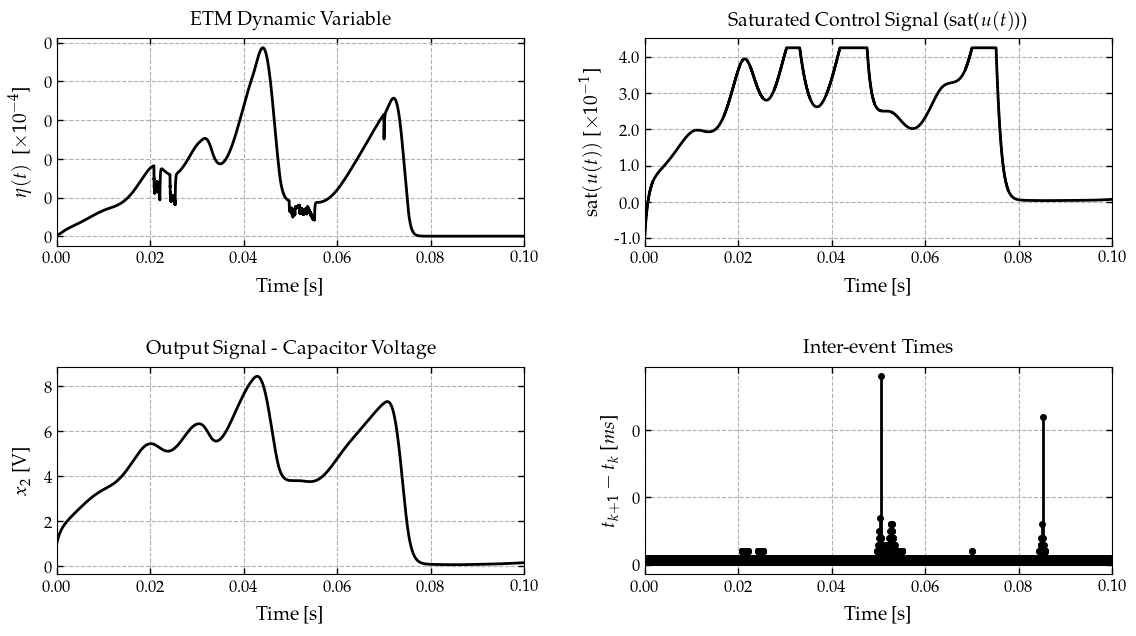

In [15]:
%matplotlib inline

fig, axs = plt.subplot_mosaic([['η', 'sat'], ['x', 'iet']], 
                              figsize=(12, 7))

trajectories = results_clsim['trajectories']
trajectories_index = 0

inter_event_times = results_clsim['inter-event-times'][trajectories_index]
event_times = np.cumsum(inter_event_times) if len(inter_event_times) > 0 else np.array([])

print("Initial States: ", trajectories[trajectories_index][2][0])
print("Number of Triggered Events: ", len(inter_event_times))

if len(inter_event_times) > 0:
    print("Minimum IET Obtained: ", min(inter_event_times))
    print("Maximum IET Obtained: ", max(inter_event_times))
    print("Average Time Between Events: ", np.mean(inter_event_times))
else:
    print("No events were triggered, so no inter-event time statistics available.")

    
plot_cfg = {
  'style': { 'color': 'black', },
  'axis': { 'title_pad': 10, 'y_digits': 0, 'x_digits': 2,
            'x_label_fontsize': 14,
            'y_label_fontsize': 14,
            'tick_fontsize': 14,},
  'limits': { 'x_min': 0.0, 'x_max': simulation_time }
}

# Plots principais
gph.plot(
    axs['η'], t, 
    [v * 1e4 for v in trajectories[trajectories_index][0]],
    xlabel='Time [s]', ylabel='$\\eta(t)\\,$ [$\\times 10^{-4}$]',
    title='ETM Dynamic Variable',
    plot_cfg=plot_cfg)

# Plot sinal de saída
gph.plot(
    axs['x'], t, np.array(trajectories[trajectories_index][2]),
    xlabel='Time [s]', ylabel=r'$x_2$ [V]',
    title='Output Signal - Capacitor Voltage',
    plot_cfg=plot_cfg)

plot_cfg1 = plot_cfg.copy()
plot_cfg1['axis']['y_digits'] = 1

gph.plot(
    axs['sat'], t, 
    [(v * 1e1) for v in trajectories[trajectories_index][3]],
    xlabel='Time [s]', ylabel='sat$(u(t))$ [$\\times 10^{-1}$]',
    title='Saturated Control Signal (sat($u(t)$))', plot_cfg=plot_cfg1)

# Plot dos IETs
if len(inter_event_times) > 0:
    stem_cfg = plot_cfg.copy()
    stem_cfg['axis']['y_digits'] = 0
    gph.stem(
         axs['iet'], event_times,
        [et * 1e3 for et in inter_event_times],
        stem_cfg=stem_cfg,
        xlabel='Time [s]', ylabel='$t_{k+1} - t_k$ [$ms$]',
        title='Inter-event Times')
else:
    axs['iet'].text(0.5, 0.5, 'No triggered events',
                    ha='center', va='center', fontsize=14,
                    transform=axs['iet'].transAxes)
    axs['iet'].set_title('Inter-event Times')
    axs['iet'].set_xlabel('Time [s]')
    axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
    axs['iet'].set_xlim([0, simulation_time])
    axs['iet'].set_ylim([0, 1])  # valor simbólico
    axs['iet'].grid(False)

plt.tight_layout(pad=3.)

In [16]:
%%skip

import concurrent.futures
import numpy as np
import control as ct
import os
import json
import itertools
import pandas as pd

# Nome do arquivo de experimento
experiment_name = "CLSim_ETMParameters_23fev2025_Exp1.json"

# Definição dos parâmetros
upsilon_values = [1e-2, 1e0, 1e2]
theta_values = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# Gerar combinações de upsilon e theta
upsilon_theta_pairs = list(itertools.product(upsilon_values, theta_values))

# Estrutura para armazenar os resultados
results_clsim_etm = {
    'upsilon_theta': [],
    'inter-event-times': [],
    'experiment_parameters': {
        'upsilon_values': upsilon_values,
        'theta_values': theta_values,
        'upsilon_theta_pairs': upsilon_theta_pairs,
    }
}

# Função para obter trajetórias


def get_trajectories(args):
  upsilon, theta = args
  etm = DynamicETM('etm', Ψ, Ξ, theta, upsilon, h)
  zoh = ZeroOrderHold()
  controller = Controller(K)

  closed_loop = ct.interconnect(
      (plant, etm.system, zoh.system, controller.system),
      connections=[
          ['plant.u1', 'controller.u1'],
          ['etm.x1_hat', 'zoh.x1_hat'],
          ['etm.x2_hat', 'zoh.x2_hat'],
          ['etm.x1', 'plant.x1'],
          ['etm.x2', 'plant.x2'],
          ['zoh.x1', 'etm.x1'],
          ['zoh.x2', 'etm.x2'],
          ['controller.x1_hat', 'zoh.x1_hat'],
          ['controller.x2_hat', 'zoh.x2_hat'],
      ],
      inplist=['plant.p1', 'plant.w1', 'controller.p1'],
      name='closed-loop system',
      outlist=['etm.n', 'plant.x1', 'plant.x2', 'controller.u1'],
      outputs=['n', 'x1', 'x2', 'u1']
  )

  etm.event_times = [0.]

  _, trajectories = ct.input_output_response(
      sys=closed_loop, T=timepts,
      U=[p1, w, p1],
      X0=[0., 0., 0.],  # Ponto inicial fixo
      params=params,
      solve_ivp_method='RK45',
      solve_ivp_kwargs={'max_step': simulation_step,
                        'first_step': simulation_step,
                        'atol': 1e-2, 'rtol': 1e-2},
  )

  inter_event_times = np.diff(etm.event_times).tolist()
  avg_inter_event_time = np.mean(
      inter_event_times) if inter_event_times else 0

  return {'upsilon': upsilon, 'theta': theta, 'avg_inter_event_time': avg_inter_event_time}


# Verificar se o arquivo já existe
if os.path.exists(experiment_name):
  with open(experiment_name, "r") as f:
    results_clsim_etm = json.load(f)
else:
  # Executar experimentos se o arquivo não existir
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories, upsilon_theta_pairs))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim_etm['upsilon_theta'].append(
        (res['upsilon'], res['theta']))
    results_clsim_etm['inter-event-times'].append(
        res['avg_inter_event_time'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim_etm, f, indent=4)

# print(results_clsim_etm)

# Criar DataFrame com colunas separadas para upsilon e theta
df = pd.DataFrame({
    'upsilon_theta': results_clsim_etm['upsilon_theta'],
    'inter-event-times': results_clsim_etm['inter-event-times']
})

# Separar as colunas de upsilon e theta
df[['upsilon', 'theta']] = pd.DataFrame(
    df['upsilon_theta'].tolist(), index=df.index)

# Criar tabela pivotada com upsilon nas colunas e theta nas linhas
pivot_df = df.pivot(index='theta', columns='upsilon',
                    values='inter-event-times')

# Exibir a tabela
print(pivot_df)